
------------------------------------------------

# Object Detection with SSD

*Author: NVIDIA*

*Editor: KodersHub*

<hr>

**SSD** is designed for object detection in real-time. Faster R-CNN uses a region proposal network to create boundary boxes and utilizes those boxes to classify objects. While it is considered the start-of-the-art in accuracy, the whole process runs at 7 frames per second. Far below what real-time processing needs. SSD speeds up the process by eliminating the need for the region proposal network. To recover the drop in accuracy, SSD applies a few improvements including multi-scale features and default boxes. These improvements allow SSD to match the Faster R-CNN’s accuracy using lower resolution images, which further pushes the speed higher. According to the following comparison, it achieves the real-time processing speed and even beats the accuracy of the Faster R-CNN. (Accuracy is measured as the mean average precision mAP: the precision of the predictions.)

## **Single Shot MultiBox Detector model for object detection**



<img src ="https://miro.medium.com/max/777/1*aex5im2aYcsk4RVKUD4zeg.jpeg">

<img src ="https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-319-46448-0_2/MediaObjects/419956_1_En_2_Fig2_HTML.gif">
_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)


## **Default boundary box**

How do we predict boundary boxes? Just like Deep Learning, we can start with random predictions and use gradient descent to optimize the model. However, during the initial training, the model may fight with each other to determine what shapes (pedestrians or cars) to be optimized for which predictions. Empirical results indicate early training can be very unstable. The boundary box predictions below work well for one category but not for others. We want our initial predictions to be diverse and not looking similar.

<img src = "https://miro.medium.com/max/767/1*7iwTsezrn-tSndx96twprA.jpeg">

If our predictions cover more shapes, like the one below, our model can detect more object types. This kind of head start makes training much easier and more stable.

<img src = "https://miro.medium.com/max/777/1*wCHRhpMRx_SaIUfeO9kJZg.jpeg">



In [ ]:
import torch
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


will load an SSD model pretrained on COCO dataset from Torch Hub.

Setting precision='fp16' will load a checkpoint trained with [mixed precision](https://arxiv.org/abs/1710.03740) into architecture enabling execution on [Tensor Cores](https://developer.nvidia.com/tensor-cores).
Handling mixed precision data requires [Apex](https://github.com/NVIDIA/apex) library.



### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

### Example

In the example below we will use the pretrained SSD model loaded from Torch Hub to detect objects in sample images and visualize the result.

To run the example you need some extra python packages installed.
These are needed for preprocessing images and visualization.

In [ ]:
%%bash
pip install numpy scipy scikit-image matplotlib

For convenient and comprehensive formatting of input and output of the model, load a set of utility methods.

In [ ]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Now, prepare the loaded model for inference

In [ ]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

Prepare input images for object detection.
(Example links below correspond to first few test images from the COCO dataset, but you can also specify paths to your local images here)

In [ ]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg',
    'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSSj0yy1QIy0_Imxwd2HgP2hgsEqjhD81FYeg&usqp=CAU'
]

Format the images to comply with the network input and convert them to tensor.

In [ ]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

Run the SSD network to perform object detection.

In [ ]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

By default, raw output from SSD network per input image contains
8732 boxes with localization and class probability distribution.
Let's filter this output to only get reasonable detections (confidence>40%) in a more comprehensive format.

In [ ]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.20) for results in results_per_input]

The model was trained on COCO dataset, which we need to access in order to translate class IDs into object names.
For the first time, downloading annotations may take a while.

In [ ]:
classes_to_labels = utils.get_coco_object_dictionary()

Finally, let's visualize our detections

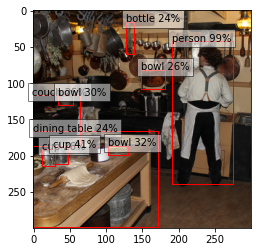

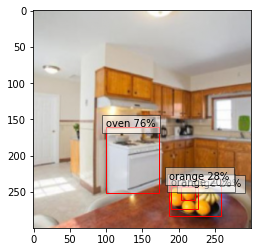

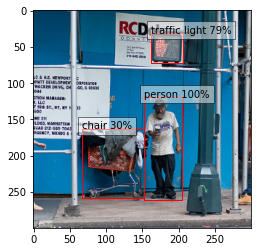

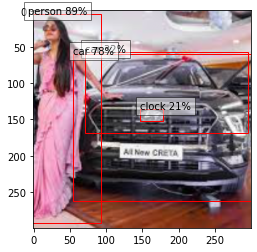

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### References

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)